# European Parliament: a view on Political Groups through the last 3000 votes.


Based on a set of 3299 votes obtained through VoteWatch.eu we create a dataset for analysis using Pandas. Using initial data visualisation techniques (like heatmaps), we then obtain an euclidean distance matrix between all political groups pairs.
A cluster map is created from the distance matrix using Ward clustering, presenting the way the different groups cluster together in a dendogram that shows the relative distance between all of them.

Using DBSCAN and SpectrumClustering in the computed affinity matrix we obtain the separate groups that can be identified by both methods, and using Multi-dimensional scaling we create 2D and 3D maps of the relative distance between all groups - in total and by Policy Area.

----

 
*This work is part of a series whose previous releases have detailed the algorithms and provided a deeper explanation of the approach that is reused here; since this is the first of the analysis which is, due to the subject matter, in English, the fundamental aspects of the approach will be desribed - but for an adidtional level of detail and references please check the other notebooks:*

* 👉 **Portuguese Parliamentary Activty: using Data Science and Open Data to define political affinity based on voting records** https://github.com/fsmunoz/pt-act-parlamentar/blob/master/Actividade%20Parlamentar%20da%20XIV%20Legislatura.ipynb
* 👉 **Budget approval 2021: Data Science and Political Activity:**  https://github.com/fsmunoz/pt-act-parlamentar/blob/master/OE2021.ipynb

# Importing data

This data was extracted from http://votewatch.eu - a site I recommend to anyone to that wants to follow the political activity in the EU; it consists of ~3300 votes from the last quarter of 2020.

In [5]:
import pandas as pd

eu_v=pd.read_csv("https://raw.githubusercontent.com/fsmunoz/pt-act-parlamentar/eu-votes-3300/EU_Parliament_votes.csv")

In [6]:
eu_v.head()

,ID,Date,Policy Area,Name,For,Against,Abstentions,Result,GUE-NGL,S&D,Greens/EFA,REG,EPP,ECR,IDG,NI
0,2324,9/14/2020,Transport & tourism,Sustainable rail market in view of COVID-19 ou...,64,0,0,Adopted,For,For,For,For,For,For,For,For
1,2325,9/14/2020,Budget,Draft amending budget no 8: Increase of paymen...,62,0,2,Adopted,For,For,For,For,For,For,For,For
2,2326,9/14/2020,Regional development,Proposal for a Council decision authorising Po...,64,0,1,Adopted,For,For,For,For,For,For,For,For
3,2327,9/14/2020,Culture & education,"Effective measures to “green” Erasmus+, Creati...",65,0,0,Adopted,For,For,For,For,For,Against,Abstain,For
4,2328,9/14/2020,Environment & public health,The EU’s role in protecting and restoring the ...,65,0,0,Adopted,For,For,For,For,For,For,For,For


Each row is a vote and the columns include the political groups position (as defined by VoteWatch.eu), the result and the policy area, amongst others.

In [7]:
eu_v.columns

Index(['ID', 'Date', 'Policy Area', 'Name', 'For', 'Against', 'Abstentions',
       'Result', 'GUE-NGL', 'S&D', 'Greens/EFA', 'REG', 'EPP', 'ECR', 'IDG',
       'NI'],
      dtype='object')

## Looking at the data

Information on the political groups can be obtained directly from the European Parliament site (https://www.europarl.europa.eu/about-parliament/en/organisation-and-rules/organisation/political-groups); a very brief description based on the above information and direct quotes (when possible) from their official sites:

* **Group of the European People's Party (Christian Democrats)**: "The EPP Group is the largest and oldest group in the European Parliament. A centre-right group, we are committed to creating a stronger and self-assured Europe, built at the service of its people. Our goal is to create a more competitive and democratic Europe, where people can build the life they want."
* **Group of the Progressive Alliance of Socialists and Democrats**: "The S&D Group is the leading centre-left political group in the European Parliament and the second largest. Our MEPs are committed to fighting for social justice, jobs and growth, consumer rights, sustainable development, financial market reform and human rights to create a stronger and more democratic Europe and a better future for everyone."
* **Renew Europe Group**: "There has never been a larger centrist group in the European Parliament. By ending the dominance of the Conservatives and the Socialists, Europeans have given us a strong mandate to change Europe for the better. At a time when the rule of law and democracy are under threat in parts of Europe, our Group will stand up for the people who suffer from the illiberal and nationalistic tendencies that we see returning in too many countries."
* **Group of the Greens/European Free Alliance**: "The Greens/European Free Alliance is a political group in the European Parliament made up of Green, Pirate and Independent MEPs as well as MEPs from parties representing stateless nations and disadvantaged minorities. The Greens/EFA project is to build a society respectful of fundamental human rights and environmental justice: the rights to self-determination, to shelter, to good health, to education, to culture, and to a high quality of life"
* **Identity and Democracy Group**: "Identity and Democracy (ID) is a new group, which is the fourth largest one in the current European Parliament"; "The Members of the ID Group base their political project on the upholding of freedom, sovereignty,  subsidiarity  and  the  identity  of  the  European  peoples  and  nations.  They  acknowledge  the  Greek-Roman  and  Christian  heritage  as the  pillars  of  European  civilisation."
* **European Conservatives and Reformists Group**: "The ECR Group is a centre-right political group in the European Parliament, founded in 2009 with a common cause to reform the EU based on euro-realism, respecting the sovereignty of nations, and focusing on economic recovery, growth and competitiveness. From its 8 founding Member States with 54 MEPs in 2009, we now have 62 members from 15 EU Member States. The ECR Group is at the forefront of generating forward-looking policy proposals to design a reformed European Union that is more flexible, decentralised and respects the wishes of its Member States. Only an EU that truly listens to its people can offer real solutions to the problems we face today. "
* **The Left group in the European Parliament - GUE/NGL**: "Our group brings together left-wing MEPs in the European Parliament. We stand up for workers, environment, feminism, peace & human rights. What unites us is the vision of a socially equitable and sustainable Europe based on international solidarity. The European Union must become a project of its people and cannot remain a project of the elites. We want equal rights for women and men, civil rights and liberties and the enforcement of human rights. Anti-Fascism and anti-racism are also a strong part of the tradition of left movements in Europe."

There is an additional group listed in the table: *NI*, which stands for *Non-Inscrits*: this isn't strictly speaking a group but it bundles every MEP that doesn't belong to a group. As per the wikipedia article (https://en.wikipedia.org/wiki/Non-Inscrits) the current MEPs come from different political backgrounds.


To visualise how the different groups vote an initial approach is a simple heatmap; for that end we subset the datafram on the political groups only and replace the voting indication with numerical values.

In [19]:
votes_hm=eu_v[["GUE-NGL","S&D", "Greens/EFA", "REG", "EPP", "ECR", "IDG", "NI"]]
votes_hmn = votes_hm.replace(["For", "Against", "Abstain", "No political line"], [1,-1,0,0])

The resulting dataframe is simply a list of voting sessions with a numeric indication of each group's vote:

In [20]:
votes_hmn

,GUE-NGL,S&D,Greens/EFA,REG,EPP,ECR,IDG,NI
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,-1,0,1
4,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
3294,-1,-1,-1,-1,-1,-1,1,0
3295,1,1,1,-1,-1,0,-1,1
3296,-1,-1,-1,-1,-1,-1,1,-1
3297,-1,-1,-1,-1,-1,-1,1,-1


Using Seaborn (https://seaborn.pydata.org/) we can then visualise it.

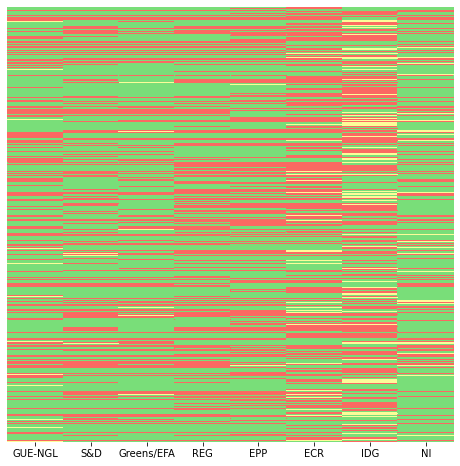

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


voting_palette = ["#FB6962","#FCFC99","#79DE79"]

fig = plt.figure(figsize=(8,8))
sns.heatmap(votes_hmn,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
           )
plt.show()

This visualisation alone can provide some initial insights; for example, the IDG seems to abstain more than the rest, and the ECR group appears to vote against more than the average. In general groups in the centre-right to right-wing seem to vote more Against than the others.

## Who votes with whom? Determining convergence in voting

An initial approach to determine how similar or dissimilar the groups are is simply to determine how many times they have voted exactly in the same way, which is what the following table reflects:

In [17]:
import collections

import numpy as np
pv_list = []
print("Total voting instances: ", votes_hm.shape[0])

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_hmn:
        pv_dict[column]=votes_hmn[votes_hmn[party] == votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

pv = pd.DataFrame(pv_list,index=votes_hm.columns)
pv

Total voting instances:  3299


,GUE-NGL,S&D,Greens/EFA,REG,EPP,ECR,IDG,NI
GUE-NGL,3299,2318,2670,2026,1612,976,938,2433
S&D,2318,3299,2642,2841,2449,1571,1086,2535
Greens/EFA,2670,2642,3299,2370,1943,1184,866,2689
REG,2026,2841,2370,3299,2708,1790,1233,2255
EPP,1612,2449,1943,2708,3299,2162,1504,1947
ECR,976,1571,1184,1790,2162,3299,1914,1261
IDG,938,1086,866,1233,1504,1914,3299,1025
NI,2433,2535,2689,2255,1947,1261,1025,3299


Using an heatmap (but this time for a different purpose and with different options) we can visualise that data in a better way.

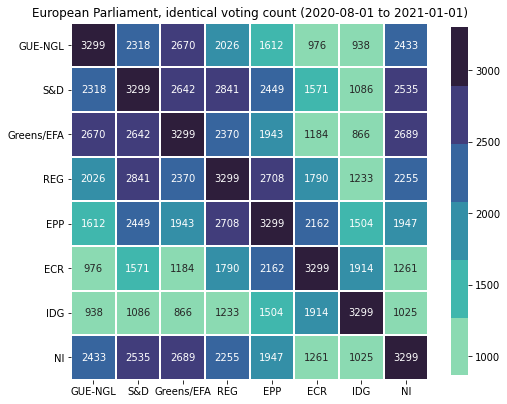

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('European Parliament, identical voting count (2020-08-01 to 2021-01-01)')

plt.show()

From this we can see, for example, that the party with whom GUE/NGL has converged the least is the IDG (and vice-versa), or that S&D converges more with the REG (and vice-versa).
This approach, while already useful, only considers the proximity based on absolute convergence - is there a better way?

## The Distance Matrix of the political groups

One improvement is to reflect the differences in voting behaviour: a party that votes In Favour is closer to a party that Abstains than to one that votes Against.
Based on this principle we compute the euclidean pairwise distance between all groups and create a distance matrix.


In [23]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show

votes_hmn = votes_hmn

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)

distmat

,GUE-NGL,S&D,Greens/EFA,REG,EPP,ECR,IDG,NI
GUE-NGL,0.000000,59.974995,45.155288,69.354164,80.318118,90.972523,89.218832,52.009614
S&D,59.974995,0.000000,48.435524,41.988094,57.323643,77.711003,86.434947,49.879856
Greens/EFA,45.155288,48.435524,0.000000,58.932164,71.833140,86.377080,90.746901,42.000000
REG,69.354164,41.988094,58.932164,0.000000,47.906158,72.166474,83.078276,60.224580
EPP,80.318118,57.323643,71.833140,47.906158,0.000000,60.819405,76.256147,69.598851
ECR,90.972523,77.711003,86.377080,72.166474,60.819405,0.000000,60.149813,82.903558
IDG,89.218832,86.434947,90.746901,83.078276,76.256147,60.149813,0.000000,85.924385
NI,52.009614,49.879856,42.000000,60.224580,69.598851,82.903558,85.924385,0.000000


The findings can be read in a similar way to the previous analysis: for example, the Greens/EFA is closer to the NI group and furthest awy from the IDG, while the EPP is most distant from GUE/NGL and has the REG has the closest group.

This pairwise analysis can fortunately be groups automatically; for this we use Ward clustering to obtain a dendogram that can be combined with a heatmap: a *clustermap* that has the advantage of automatically reordering the columns and rows to show how the groups are positioned in terms of distance.

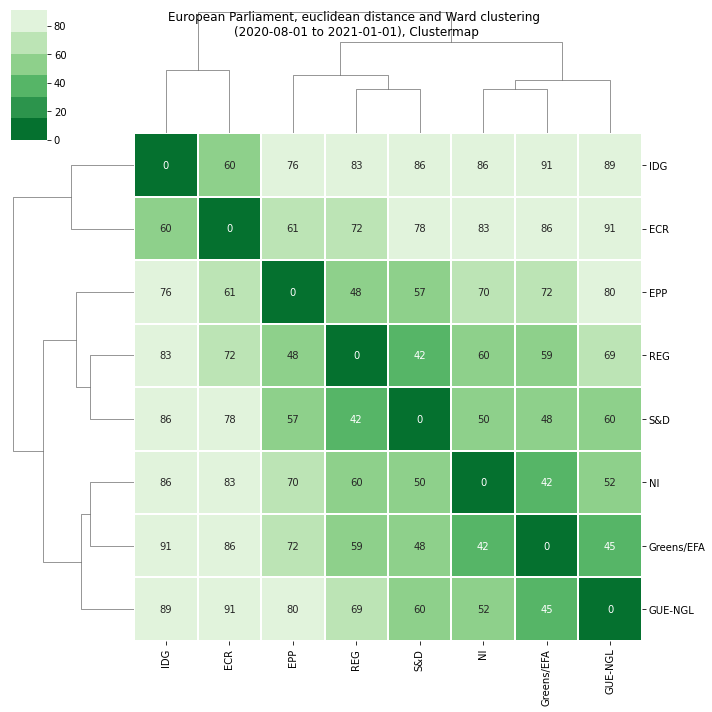

In [31]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True)

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Greens_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(10,10)).fig.suptitle('European Parliament, euclidean distance and Ward clustering \n(2020-08-01 to 2021-01-01), Clustermap')

plt.show()

The results are much more readable: we can clearly see that:

* The first split separates the IDG and ECR from the rest.
* The next split separates the EPP, REF and S&D (the last two closer together)
* Finally the GUE/NGL, the Greens/EFA and the NI constitute a separate branch (with GUE/NGL branching out first)

## DBSCAN and Spectrum Clustering

An additional line of inquery is to determine, based on the relative affinity, how many groups can be identified, or how do the parties cluster when divided by a fixed number of clusters.

The first step in answering this is to compute the affinity matrix from the distance matrix. We start by normalising the distance matrix.

In [33]:
import numpy as np

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
pd.DataFrame(distmat_mm, distmat.index, distmat.columns)

,GUE-NGL,S&D,Greens/EFA,REG,EPP,ECR,IDG,NI
GUE-NGL,0.000000,0.659265,0.496362,0.762364,0.882883,1.000000,0.980723,0.571707
S&D,0.659265,0.000000,0.532419,0.461547,0.630120,0.854225,0.950121,0.548296
Greens/EFA,0.496362,0.532419,0.000000,0.647802,0.789614,0.949485,0.997520,0.461678
REG,0.762364,0.461547,0.647802,0.000000,0.526600,0.793278,0.913224,0.662008
EPP,0.882883,0.630120,0.789614,0.526600,0.000000,0.668547,0.838233,0.765054
ECR,1.000000,0.854225,0.949485,0.793278,0.668547,0.000000,0.661187,0.911303
IDG,0.980723,0.950121,0.997520,0.913224,0.838233,0.661187,0.000000,0.944509
NI,0.571707,0.548296,0.461678,0.662008,0.765054,0.911303,0.944509,0.000000


We can now obtain the affinity matrix.

In [34]:
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)
affinmat_mm 

,GUE-NGL,S&D,Greens/EFA,REG,EPP,ECR,IDG,NI
GUE-NGL,1.000000,0.340735,0.503638,0.237636,0.117117,0.000000,0.019277,0.428293
S&D,0.340735,1.000000,0.467581,0.538453,0.369880,0.145775,0.049879,0.451704
Greens/EFA,0.503638,0.467581,1.000000,0.352198,0.210386,0.050515,0.002480,0.538322
REG,0.237636,0.538453,0.352198,1.000000,0.473400,0.206722,0.086776,0.337992
EPP,0.117117,0.369880,0.210386,0.473400,1.000000,0.331453,0.161767,0.234946
ECR,0.000000,0.145775,0.050515,0.206722,0.331453,1.000000,0.338813,0.088697
IDG,0.019277,0.049879,0.002480,0.086776,0.161767,0.338813,1.000000,0.055491
NI,0.428293,0.451704,0.538322,0.337992,0.234946,0.088697,0.055491,1.000000


We will use *Density-based spatial clustering of applications with noise* (DBSCAN) to as our data clustering algorithm.

In [46]:
from sklearn.cluster import DBSCAN

dbscan_labels = DBSCAN(eps=1.1).fit(affinmat_mm)
dbscan_labels.labels_
dbscan_dict = dict(zip(distmat_mm,dbscan_labels.labels_))
dbscan_dict

{'GUE-NGL': 0,
 'S&D': 0,
 'Greens/EFA': 0,
 'REG': 0,
 'EPP': 0,
 'ECR': -1,
 'IDG': -1,
 'NI': 0}

We get a simple split that identified the ECR and the IDG on one side, and all the others grouped together on the other cluster.

A different approach is to use *Spectral Clustering*, an algorithm that can be initialised with a pre-determine naumber of clusters; here we set it at 3.

In [47]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

print(sc_dict)

{'GUE-NGL': 2, 'S&D': 0, 'Greens/EFA': 2, 'REG': 0, 'EPP': 0, 'ECR': 1, 'IDG': 1, 'NI': 2}


The results are consistent with what one would expect when looking at the previous clustermap:
* One group with the ECR and IDG
* One group with the S&D, REG and EPP
* One group with the GUE/NGL, Greens/EFA and NI

## Multidimensional Scaling

Based on what we've done above we can now visualise the relative distances between all the groups in a map: this can be achieved by Multi-dimensional scaling, a method that reduces the dimensions while keeping the relative distances.

What this means is that we can reduce to 2 or 3 dimensions and obtain a plot of how close the parties are that maintains the relative distance; we can also use the information obtained from Spectral Clustering in the form of the colours od the data points, thus combining relative distance and clustering.

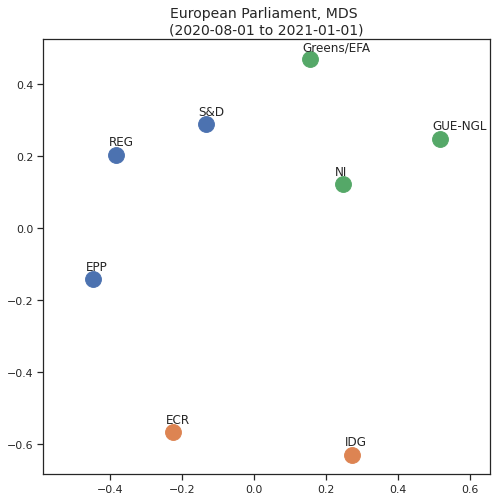

In [53]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_
coords
## Graphic options
sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))

plt.title('European Parliament, MDS \n(2020-08-01 to 2021-01-01)', fontsize=14)

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))
plt.show()

This view is perhaps one of the most useful in getting an overview of how the political groups relate to each other based on their voting records.

The 3D equivalent can be seen here:

In [57]:
## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

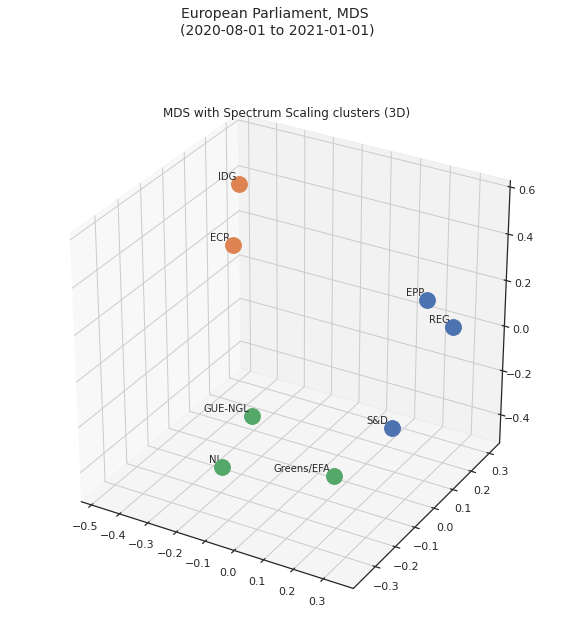

In [58]:
from sklearn.manifold import MDS
import mpl_toolkits.mplot3d
import random
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_
coords
## Graphic options
sns.set()
sns.set_style("ticks")


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('European Parliament, MDS \n(2020-08-01 to 2021-01-01)', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(distmat_mm.columns, coords[:, 0], coords[:, 1], coords[:, 2]):
    #ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()

## MDS per Policy Area

Finally we can apply the 2D MDS and clustering to each individual Policy Area; the approach is the same but applied to a subset of the votes, providing the relative distance of the parties in the different domains.

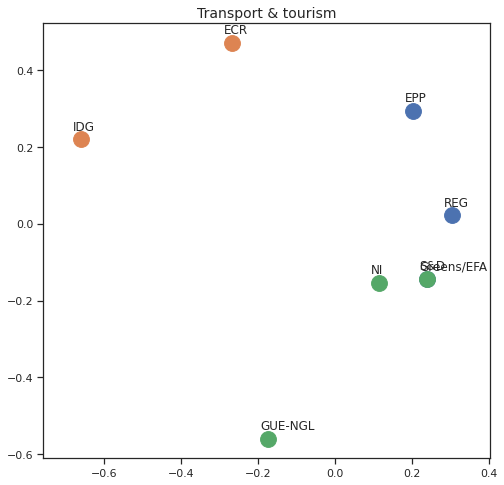

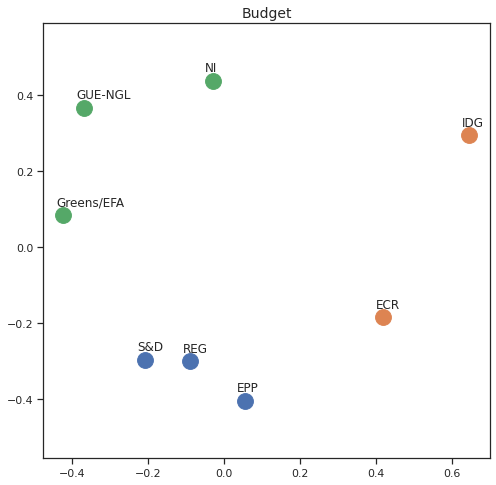

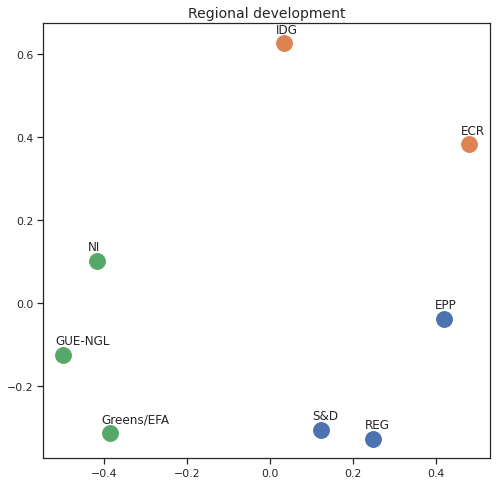

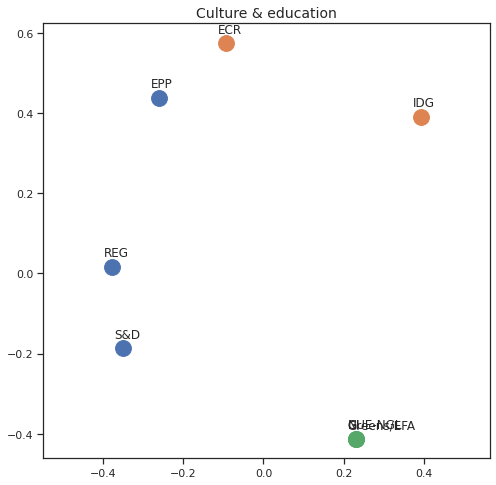

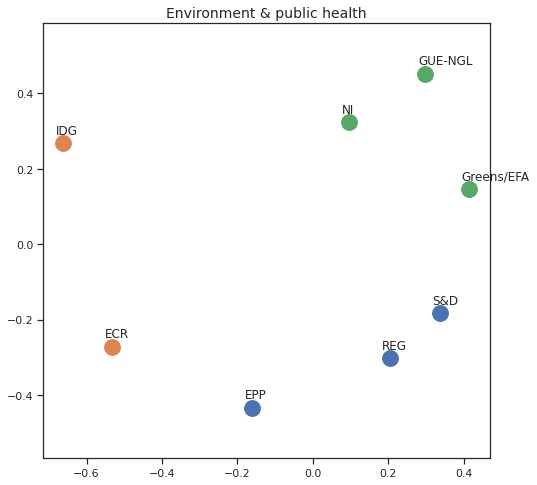

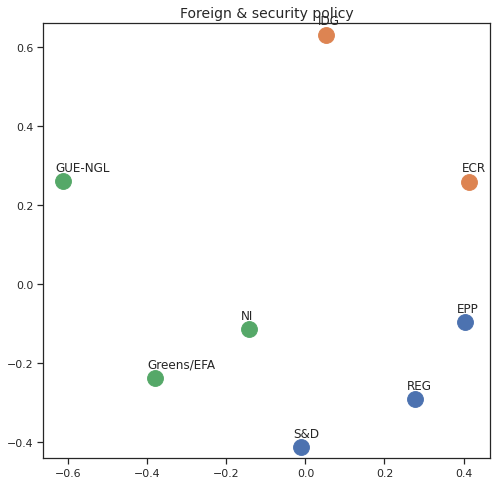

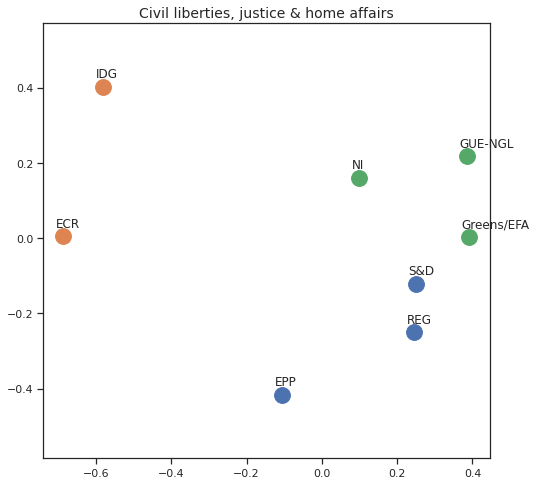

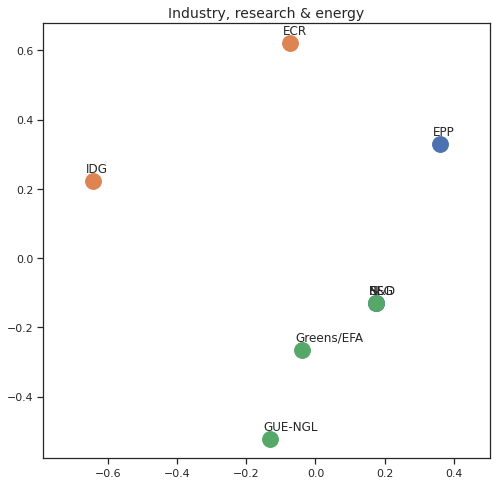

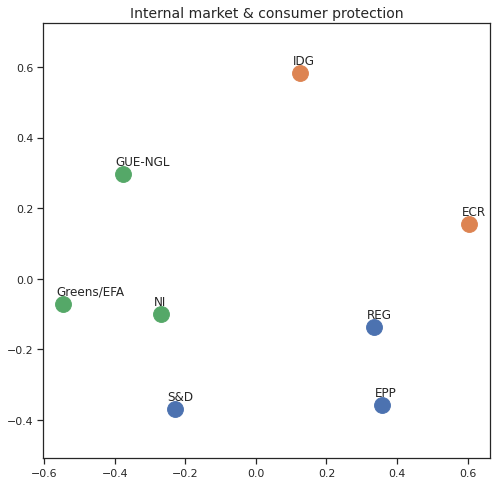

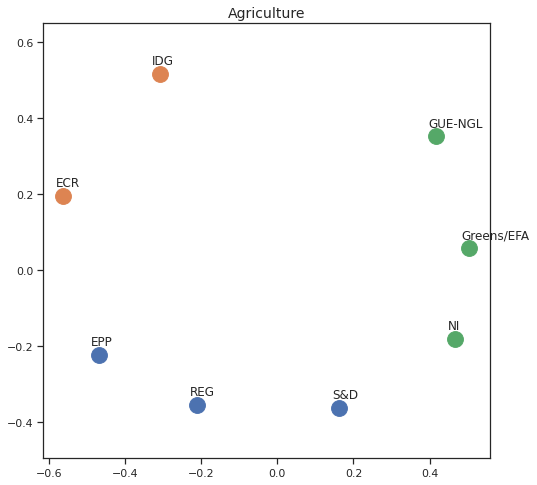

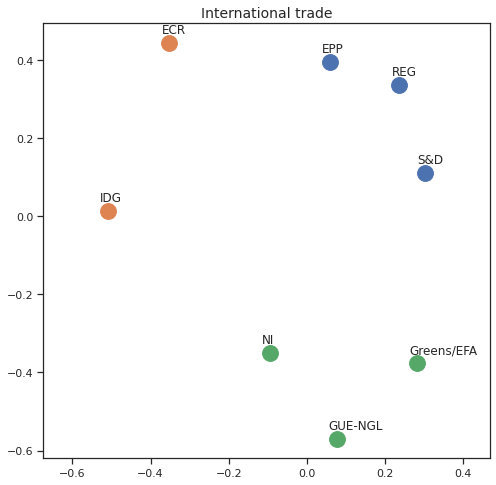

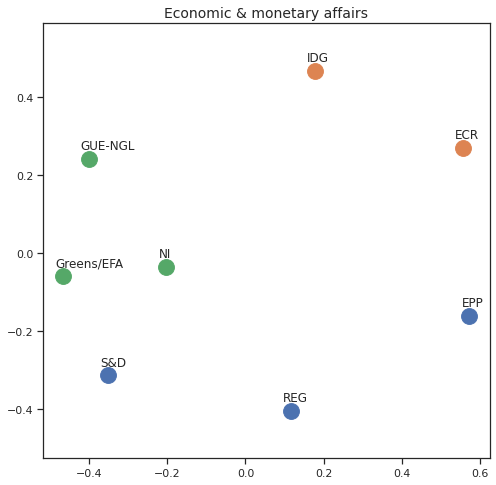

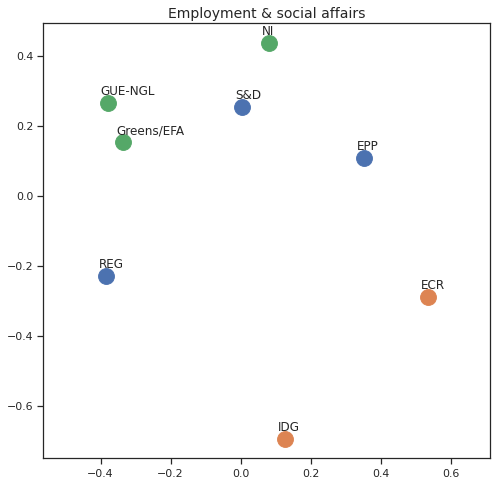

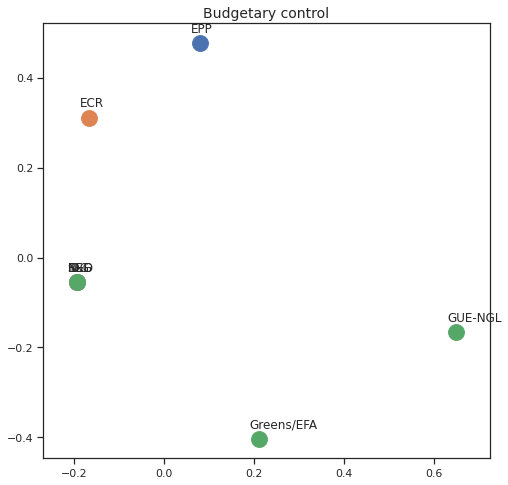

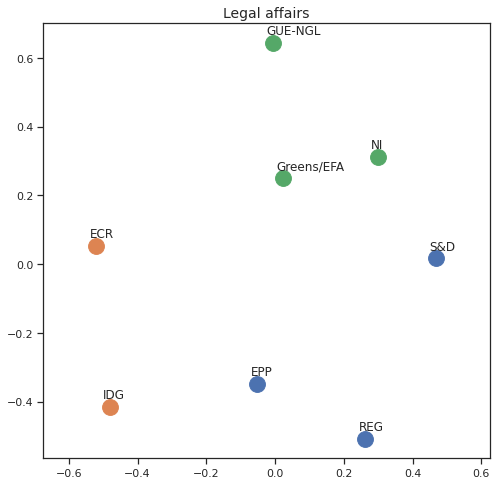

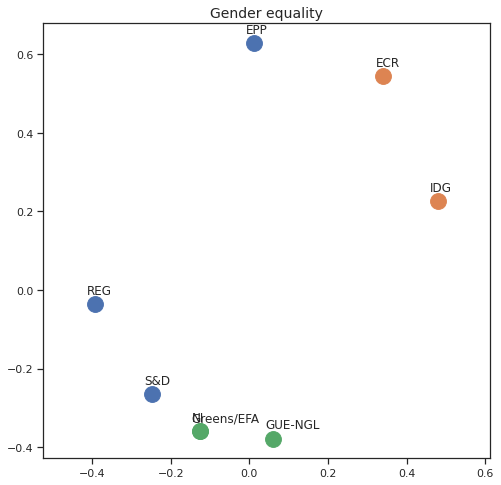

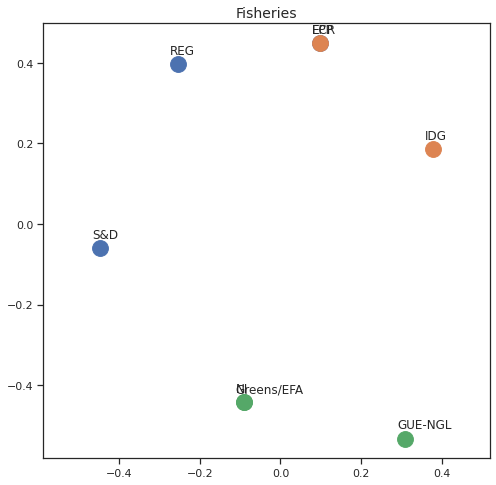

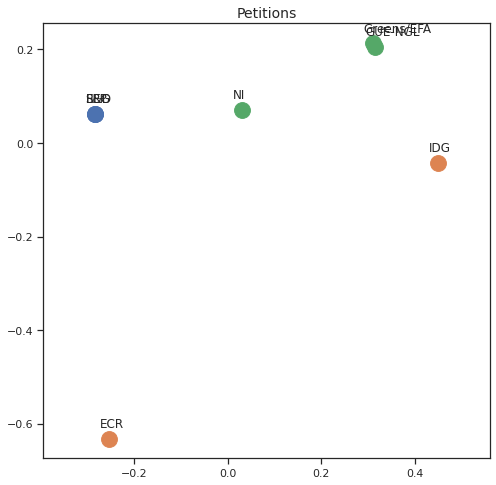

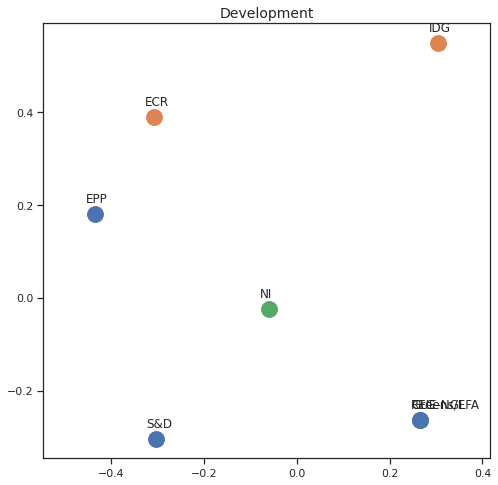

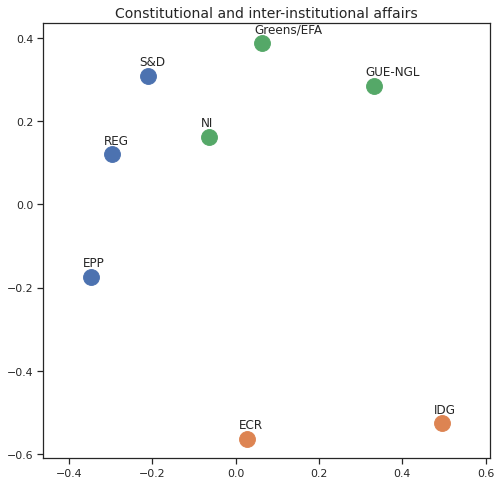

In [60]:
for area in eu_v["Policy Area"].unique():
    varea=eu_v[eu_v["Policy Area"] == area]
    avotes_hm=varea[["GUE-NGL","S&D", "Greens/EFA", "REG", "EPP", "ECR", "IDG", "NI"]]
    avotes_hmn = avotes_hm.replace(["For", "Against", "Abstain", "No political line"], [1,-1,0,0])
 
    avotes_t = avotes_hmn.transpose()
    apwdist = pdist(avotes_t, metric='euclidean')
    adistmat = pd.DataFrame(
        squareform(apwdist), # pass a symmetric distance matrix
        columns = avotes_t.index,
        index = avotes_t.index)
    adistmat_mm=((adistmat-adistmat.min().min())/(adistmat.max().max()-adistmat.min().min()))*1
    
    aaffinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, adistmat.columns)

    asc = SpectralClustering(3, affinity="precomputed",random_state=2020).fit_predict(aaffinmat_mm)
    asc_dict = dict(zip(adistmat,asc))   
    
    amds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
    aresults = amds.fit(adistmat_mm.values)
    acoords = aresults.embedding_
    
    sns.set()
    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=(8,8))

    plt.title(area, fontsize=14)

    for label, x, y in zip(adistmat_mm.columns, acoords[:, 0], acoords[:, 1]):
        ax.scatter(x, y, c = "C"+str(asc_dict[label]), s=250)
        #ax.scatter(x, y, s=250)
        ax.axis('equal')
        ax.annotate(label,xy = (x-0.02, y+0.025))
    plt.show()    


---
**2021, Frederico Muñoz**